In this notebook, we download a PDB structure and load it to this notebook. Then, we simulate AFM process by a dilation from the given tip shape, creating AFM test data for blind tip reconstruction.

# Download a structure and load it to this notebook

In [1]:
using Plots, HTTP, DelimitedFiles, Statistics
using Revise, MDToolbox
ENV["COLUMNS"] = 150; #display width for MDToolbox

In [2]:
#download("https://files.rcsb.org/download/1OE9.pdb", "./1OE9.pdb")
download("https://files.rcsb.org/download/1OE9.pdb", "./6BNO.pdb")

"./6BNO.pdb"

In [3]:
#t = mdload("1OE9.pdb")
t = mdload("6BNO.pdb")
t = t["protein and chain A"]
decenter!(t)

1x1 TrjArray{Float64, Int64}
|     2.09     0.46    50.94 |

# DilationによるAFMのエミュレーション

In [4]:
# 針や解像度のパラメータの設定
width = 15
height = 15
resolution = 15
radius = 25.0
angle = 10.0
param = AfmizeConfig(angle * (pi / 180),
        radius, 
        MDToolbox.Point2D(-height * resolution, -width * resolution), 
        MDToolbox.Point2D(height * resolution, width * resolution), 
        MDToolbox.Point2D(resolution, resolution), 
        MDToolbox.defaultParameters())

AfmizeConfig(0.17453292519943295, 25.0, MDToolbox.Point2D{Int64}(-225, -225), MDToolbox.Point2D{Int64}(225, 225), MDToolbox.Point2D{Int64}(15, 15), Dict("SI" => 2.1, "CH1" => 1.7, "CZ3" => 1.7, "C" => 1.7, "CH" => 1.7, "ND2" => 1.55, "NE1" => 1.55, "MG" => 1.73, "P" => 1.8, "GLY" => 2.25…))

(xc, yc) = (4, 4)


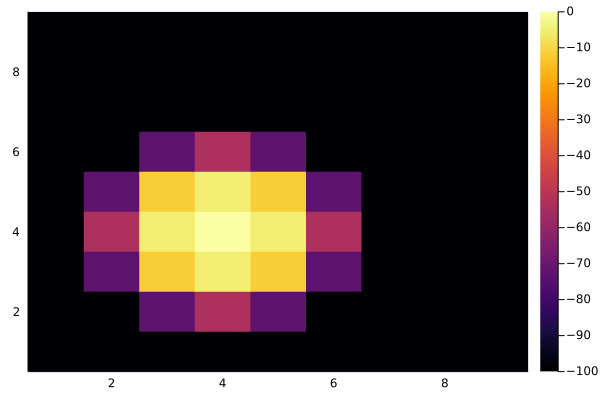

In [11]:
tip_single = zeros(Float64, 9, 9)
MDToolbox.afmize!(tip_single, param)
heatmap(collect(1:9), collect(1:9), tip_single, clim=(-100, 0))
#xlabel!("X coordinate [Å]", fontsize=35)
#ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [12]:
1:7 11:18

LoadError: syntax: extra token "11" after end of expression

In [35]:
tip = [tip_single tip_single]
tip = tip[:, [1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 16]] 

9×11 Matrix{Float64}:
 -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -152.23    -138.426   -152.23    -189.939   -244.136
 -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939
 -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23
 -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426
 -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23
 -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939
 -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -152.23    -138.426   -152.23    -189.939   -244.136
 -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -233.967   -223.495   -233.967   -263.659   -308.564
 -379.253  -341.33    -316.9

In [36]:
size(tip)

(9, 11)

In [48]:
function translate_tip_mean(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)

    p_min = minimum(P)
    weight_x = sum(P .- p_min, dims=2)[:]
    if all(weight_x .< 10.0^(-8))
        weight_x .= 1.0
    end
    id_x = round(Int, sum(weight_x .* collect(1.0:1.0:tip_xsiz)) / sum(weight_x))
    weight_y = sum(P .- p_min, dims=1)[:]
    if all(weight_y .< 10.0^(-8))
        weight_y .= 1.0
    end
    id_y = round(Int, sum(weight_y .* collect(1.0:1.0:tip_ysiz)) / sum(weight_y))

    p_max = maximum(P)
    P_new = deepcopy(P)
    P_new .= p_min .- p_max
    
    pxmin = max(1-xc, 1-id_x)
    pymin = max(1-yc, 1-id_y)
    pxmax = min(tip_xsiz-xc, tip_xsiz-id_x)
    pymax = min(tip_ysiz-yc, tip_ysiz-id_y)
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id_x+px, id_y+py] .- p_max
        end
    end
    return P_new
end

translate_tip_mean (generic function with 1 method)

In [49]:
tip = translate_tip_mean(tip)

9×11 Matrix{Float64}:
 -189.939   -152.23    -138.426   -152.23    -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -379.253
 -123.83     -73.4385   -53.3564   -73.4385  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -379.253
  -73.4385   -11.7712    -5.0      -11.7712   -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -379.253
  -53.3564    -5.0        0.0       -5.0      -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -379.253
  -73.4385   -11.7712    -5.0      -11.7712   -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -379.253
 -123.83     -73.4385   -53.3564   -73.4385  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -379.253
 -189.939   -152.23    -138.426   -152.23    -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -379.253
 -263.659   -233.967   -223.495   -233.967   -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -379.253
 -341.33    -316.988   -30

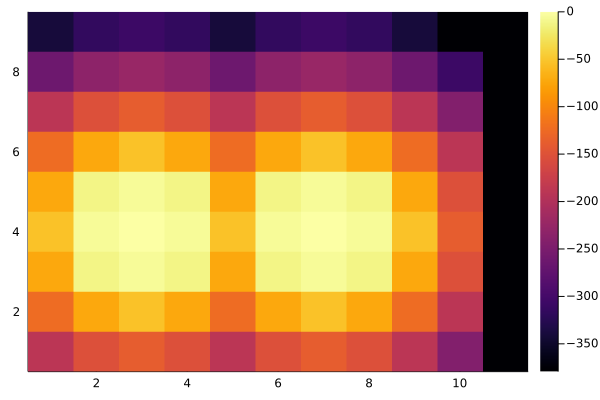

In [50]:
heatmap(tip)

In [51]:
q = readdlm("../quaternion/QUATERNION_LIST_576_Orient");

In [52]:
using Random

models = t[0, :]
surfs = []
images = []

for i in randperm(MersenneTwister(777), 576)
    t_rotated = MDToolbox.rotate(t, q[i, :])
    surf = MDToolbox.surfing(t_rotated, param)
    image = idilation(surf, tip)
    models = vcat(models, t_rotated)
    push!(surfs, surf)
    push!(images, image)
end

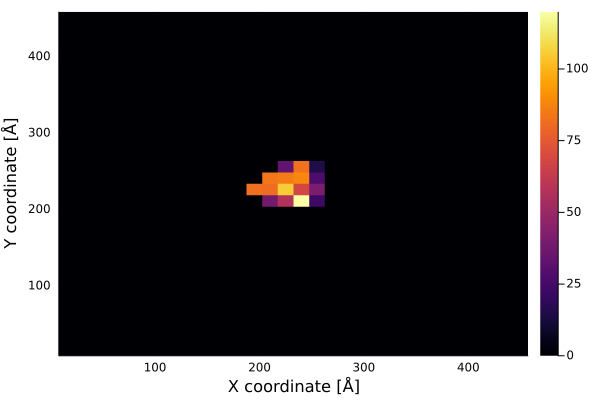

In [53]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, surfs[1])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

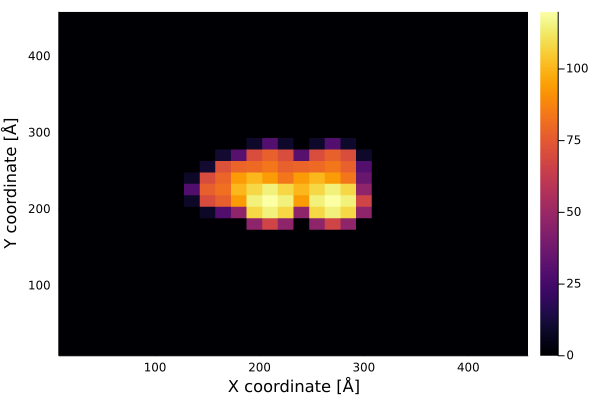

In [54]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, images[1])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [55]:
images_randn = deepcopy(images)

for i in 1:length(images)
    images_randn[i] .= images[i] .+ 3.0 * randn(eltype(images[i]), size(images[i]))
end

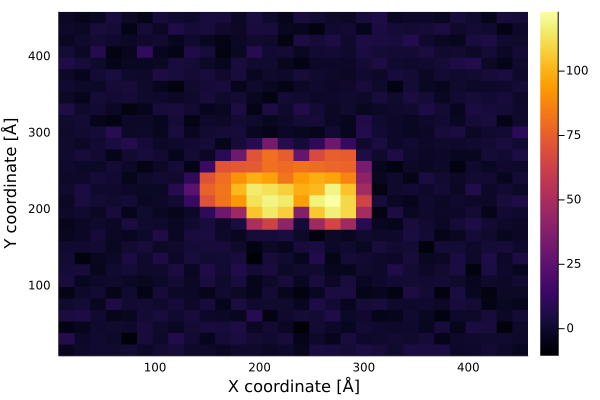

In [56]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, images_randn[1])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [57]:
using BSON: @save, @load
@save "prepare_test_data.bson" width height resolution radius angle param models tip surfs images images_randn

In [58]:
mdsave("models.pdb", models)